In [1]:
################################################################################################################
#Developed by Bahareh Kamali (1/7/2020) and adapted by Jonathan Ojeda 5/1/2021 QAAFI UQ
# Code functionalities:
# Calculate the main (ME) and total effect (TE) of a series of factors on the variability of a selected variable.

#ME explains the share of the components to crop yield variability without interactions, 
#i.e. if ME=1, the assessed factors explain the entire proportion of crop yield variability, 
#but if M<1, residuals exist which means additional factors are required to explain this variability. 
#TE represents the interaction of a given factor with other factors, i.e. high TE values for a given 
#factor denote high interactions of that factor with other factors, therefore, TE does not include residuals. 
#################################################################################################################

In [1]:
#Required packages
import os,csv,json,sys,shutil,random,glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import gridspec
import matplotlib.cm as cm
from matplotlib import colors
import matplotlib
from matplotlib.lines import Line2D
import math,zmq
from shutil import copyfile
global str
import datetime
import pandas as pd
import threading
import seaborn as sns
import matplotlib.ticker as ticker

font = {'family' : 'verdana', 'size'   : 10}
matplotlib.rc('font', **font)
from math import sqrt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#Tool to minimize code and see only figures

from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

# Read dataset (be sure data is an average across years -if years are part of the analysis-)

In [100]:
#Get dataset
DATAA0 = pd.read_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\var.csv')
df=DATAA0.drop(['Unnamed: 0'], axis=1)
DATAA1=df.dropna()

# First we need to create qualitative clusters for each variable involved in the variance

In [101]:
#Create Cluster of selected variables

thres1=np.percentile(DATAA1["TempIn"], 30)
thres2=np.percentile(DATAA1["TempIn"], 60)
DATAA1['TMPCluster']='Med'
DATAA1['TMPCluster'][DATAA1["TempIn"]<thres1]='Low'
DATAA1['TMPCluster'][DATAA1["TempIn"]>thres2]='High'

thres1=np.percentile(DATAA1["RainIn"], 30)
thres2=np.percentile(DATAA1["RainIn"],60)
DATAA1['RainInCluster']='Med'
DATAA1['RainInCluster'][DATAA1["RainIn"]<thres1]='Low'
DATAA1['RainInCluster'][DATAA1["RainIn"]>thres2]='High'

thres1=np.percentile(DATAA1["RadiationIn"], 30)
thres2=np.percentile(DATAA1["RadiationIn"], 60)
DATAA1['RadCluster']='Med'
DATAA1['RadCluster'][DATAA1["RadiationIn"]<thres1]='Low'
DATAA1['RadCluster'][DATAA1["RadiationIn"]>thres2]='High'

thres1=np.percentile(DATAA1["DOY"], 30)
thres2=np.percentile(DATAA1["DOY"], 60)
DATAA1['PDateCluster']='Med'
DATAA1['PDateCluster'][DATAA1["DOY"]<thres1]='Low'
DATAA1['PDateCluster'][DATAA1["DOY"]>thres2]='High'

thres1=np.percentile(DATAA1["PAWC"], 30)
thres2=np.percentile(DATAA1["PAWC"], 60)
DATAA1['PAWCCluster']='Med'
DATAA1['PAWCCluster'][DATAA1["PAWC"]<thres1]='Low'
DATAA1['PAWCCluster'][DATAA1["PAWC"]>thres2]='High'

<ipython-input-101-eedde24fe7e6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATAA1['TMPCluster'][DATAA1["TempIn"]<thres1]='Low'
<ipython-input-101-eedde24fe7e6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATAA1['TMPCluster'][DATAA1["TempIn"]>thres2]='High'
<ipython-input-101-eedde24fe7e6>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATAA1['RainInCluster'][DATAA1["RainIn"]<thres1]='Low'
<ipython-input-101-eedde24fe7e6>

# Quantify the variance crontribution from 5 variables

Note: Initially we need to create a new dataframe grouping based on the selected variables of analysis (see data1 dataframe)

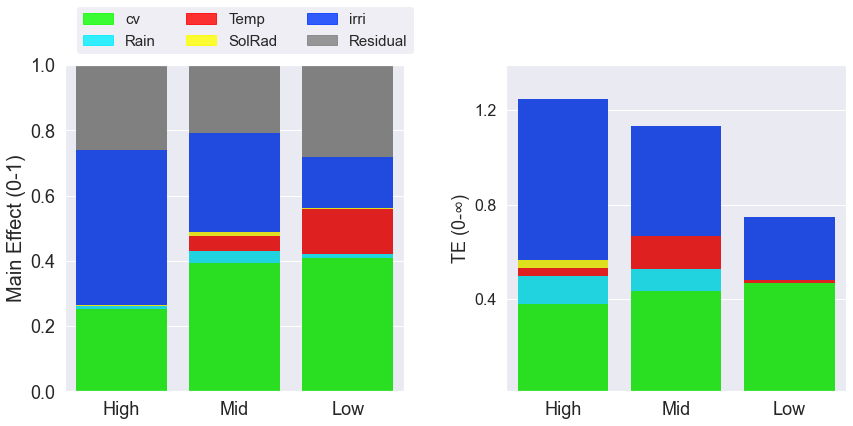

In [102]:
#Create new categories and names
data1=DATAA1.groupby(["env_name","irr","cultivar","TMPCluster","RadCluster","RainInCluster"])['biomass'].mean().reset_index(name='biomass')

data1.loc[data1.cultivar == 0, 'cv'] = "GS"
data1.loc[data1.cultivar == 1, 'cv'] = "SS"
data1.loc[data1.cultivar == 2, 'cv'] = "PS"
data1.loc[data1.cultivar == 3, 'cv'] = "PI"

data1.loc[data1.irr == 1, 'irri'] = "R"
data1.loc[data1.irr == 2, 'irri'] = "I"

data1['cv_irri'] = data1['cv']+"_"+data1['irri']

data=data1.drop(['irr','cultivar'], axis=1)

Components=["cv","irri","RainInCluster",'TMPCluster','RadCluster']
Envtype=['High','Mid','Low']
c1,c2,c3,c4,c5=[],[],[],[],[]

for i in Envtype:
    GridDATA=data[data['env_name']==i]
    GridDATA=GridDATA.reset_index()
    GridDATA=GridDATA.drop( columns='env_name')
    GridDATA=GridDATA.drop( columns='index')
    totalME=[]
    totalTE=[]
    for comp in Components:
        remaining_components=["cv","RainInCluster",'TMPCluster','RadCluster',"irri"]    
        remaining_components.remove(comp)
        TS1_df=list(GridDATA.groupby(remaining_components)['biomass'].mean())
        TS1=1-(np.var(TS1_df)/np.var(list(GridDATA["biomass"])))
        
        TOF_df=list(GridDATA.groupby(comp)['biomass'].mean())
        TOP=(np.var(TOF_df)/np.var(list(GridDATA["biomass"])))
        
        c2.append(i)
        c3.append(comp)
        c4.append(TS1)
        c5.append(TOP)
        totalME.append(TOP)
        totalTE.append(TS1)
    # print(sum(totalME))
    # print(sum(totalTE))
                
Summary={'Envtype':c2,
         'Components': c3,
         'Total Effect':c4,
         'Main Effect':c5}
TS_Summary=pd.DataFrame.from_dict(Summary)
#TS_Summary.to_csv('TS_Summary.csv')

TS_Summary1b=TS_Summary[TS_Summary["Components"]=="cv"]
TS_Summary1b=TS_Summary1b.reset_index(drop=True)

TS_Summary2b=TS_Summary[TS_Summary["Components"]=="RainInCluster"]
TS_Summary2b=TS_Summary2b.reset_index(drop=True)
TS_Summary2b["Main Effect"]=TS_Summary2b["Main Effect"]+TS_Summary1b["Main Effect"]

TS_Summary3b=TS_Summary[TS_Summary["Components"]=="TMPCluster"]
TS_Summary3b=TS_Summary3b.reset_index(drop=True)
TS_Summary3b["Main Effect"]=TS_Summary3b["Main Effect"]+TS_Summary2b["Main Effect"]

TS_Summary4=TS_Summary[TS_Summary["Components"]=="RadCluster"]
TS_Summary4b=TS_Summary4.reset_index(drop=True)
TS_Summary4b["Main Effect"]=TS_Summary4b["Main Effect"]+TS_Summary3b["Main Effect"]

TS_Summary5b=TS_Summary[TS_Summary["Components"]=="irri"]
TS_Summary5b=TS_Summary5b.reset_index(drop=True)
TS_Summary5b["Main Effect"]=TS_Summary5b["Main Effect"]+TS_Summary4b["Main Effect"]

TS_SummaryDic={'Envtype':c2,
         'Components': c3,
         'Total Effect':np.ones(len(c2)),
         'Main Effect':np.ones(len(c2))}
TS_Summary6b=pd.DataFrame.from_dict(TS_SummaryDic)

#######################
#FIGURE#
#######################
fig = plt.figure(figsize=(14,6))

ax = plt.subplot(1,2,1)
sns.barplot(x = 'Envtype', y = 'Main Effect',data=TS_Summary6b, color = "grey", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Main Effect',data=TS_Summary5b, color = "#0138ff", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Main Effect',data=TS_Summary4b, color = "yellow", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Main Effect',data=TS_Summary3b, color = "red", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Main Effect',data=TS_Summary2b, color = "#01eeff", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Main Effect',data=TS_Summary1b, color = "#0eff01", linewidth=0)
#plt.title('Main Effect',fontsize=13)
plt.ylim([0,1])

green_patch = mpatches.Patch(color='#0eff01',alpha=.8,label='cv')
lightblue_patch = mpatches.Patch(color='#01eeff',alpha=.8,label='Rain')
red_patch = mpatches.Patch(color='red',alpha=.8,label='Temp')
yellow_patch = mpatches.Patch(color='yellow',alpha=.8,label='SolRad')
blue_patch = mpatches.Patch(color='#0138ff',alpha=.8,label='irri')
grey_patch = mpatches.Patch(color='grey',alpha=.8,label='Residual')

leg=plt.legend(handles=[green_patch,lightblue_patch,red_patch,yellow_patch,blue_patch,grey_patch],fontsize=15,
               loc=4,ncol=3, bbox_to_anchor=[1.05, 1.01])   
leg.get_frame().set_linewidth(0.0)

plt.xlabel('')
plt.ylabel('Main Effect (0-1)',fontsize=20)
ax.yaxis.set_tick_params(labelsize=18)
ax.xaxis.set_tick_params(labelsize=18)

######################
ax = plt.subplot(1,2,2)
sns.set()

TS_Summary1=TS_Summary[TS_Summary["Components"]=="cv"]
TS_Summary1=TS_Summary1.reset_index(drop=True)

TS_Summary2=TS_Summary[TS_Summary["Components"]=="RainInCluster"]
TS_Summary2=TS_Summary2.reset_index(drop=True)
TS_Summary2["Total Effect"]=TS_Summary2["Total Effect"]+TS_Summary1["Total Effect"]

TS_Summary3=TS_Summary[TS_Summary["Components"]=="TMPCluster"]
TS_Summary3=TS_Summary3.reset_index(drop=True)
TS_Summary3["Total Effect"]=TS_Summary3["Total Effect"]+TS_Summary2["Total Effect"]

TS_Summary4=TS_Summary[TS_Summary["Components"]=="RadCluster"]
TS_Summary4=TS_Summary4.reset_index(drop=True)
TS_Summary4["Total Effect"]=TS_Summary4["Total Effect"]+TS_Summary3["Total Effect"]

TS_Summary5=TS_Summary[TS_Summary["Components"]=="irri"]
TS_Summary5=TS_Summary5.reset_index(drop=True)
TS_Summary5["Total Effect"]=TS_Summary5["Total Effect"]+TS_Summary4["Total Effect"]

sns.barplot(x = 'Envtype', y = 'Total Effect',data=TS_Summary5, color = "#0138ff", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Total Effect',data=TS_Summary4, color = "yellow", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Total Effect',data=TS_Summary3, color = "red", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Total Effect',data=TS_Summary2, color = "#01eeff", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Total Effect',data=TS_Summary1, color = "#0eff01", linewidth=0)
ax.set_ylim([0,1.4])

#plt.title('Total Effect',fontsize=13)
plt.xlabel('')
plt.ylabel('TE (0-\u221E)',fontsize=18)
ax.yaxis.set_tick_params(labelsize=16)
ax.xaxis.set_tick_params(labelsize=18)
ax.set_ylim([0.01,1.39])
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.4))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

plt.subplots_adjust(wspace=0.3, hspace=0)
#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\L.png', dpi=300, bbox_inches='tight', pad_inches=0)
hide_toggle()

# Quantify the variance crontribution from 7 variables

Note: please see the difference between the data1 dataframe from the previous cell. Now we have 7 variables in the contribution assessment

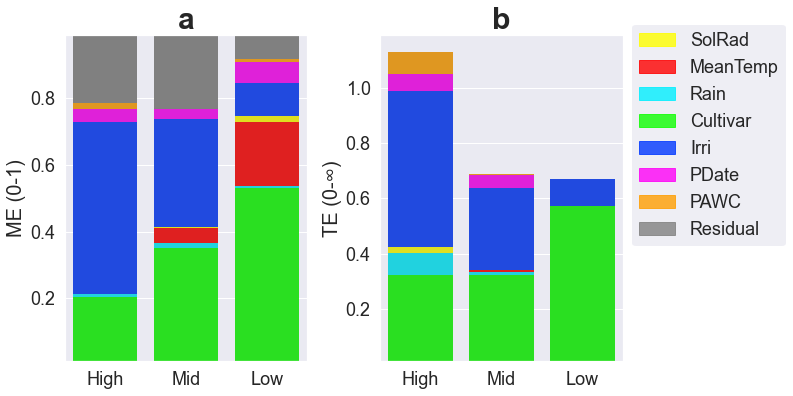

In [121]:
#Create new categories and names
data1=DATAA1.groupby(["env_name","irr","cultivar","TMPCluster","RadCluster","RainInCluster","PDateCluster",'PAWCCluster'])['biomass'].mean().reset_index(name='biomass')

data1.loc[data1.cultivar == 0, 'cv'] = "GS"
data1.loc[data1.cultivar == 1, 'cv'] = "SS"
data1.loc[data1.cultivar == 2, 'cv'] = "PS"
data1.loc[data1.cultivar == 3, 'cv'] = "PI"

data1.loc[data1.irr == 1, 'irri'] = "R"
data1.loc[data1.irr == 2, 'irri'] = "I"

data1['cv_irri'] = data1['cv']+"_"+data1['irri']

data=data1.drop(['irr','cultivar'], axis=1)

Components=["cv","irri","RainInCluster",'TMPCluster','RadCluster',"PDateCluster",'PAWCCluster']
Envtype=['High','Mid','Low']
c1,c2,c3,c4,c5=[],[],[],[],[]

for i in Envtype:
    GridDATA=data[data['env_name']==i]
    GridDATA=GridDATA.reset_index()
    GridDATA=GridDATA.drop( columns='env_name')
    GridDATA=GridDATA.drop( columns='index')
    totalME=[]
    totalTE=[]
    for comp in Components:
        remaining_components=["cv","RainInCluster",'TMPCluster','RadCluster',"irri","PDateCluster",'PAWCCluster']    
        remaining_components.remove(comp)
        TS1_df=list(GridDATA.groupby(remaining_components)['biomass'].mean())
        TS1=1-(np.var(TS1_df)/np.var(list(GridDATA["biomass"])))
        
        TOF_df=list(GridDATA.groupby(comp)['biomass'].mean())
        TOP=(np.var(TOF_df)/np.var(list(GridDATA["biomass"])))
        
        c2.append(i)
        c3.append(comp)
        c4.append(TS1)
        c5.append(TOP)
        totalME.append(TOP)
        totalTE.append(TS1)
    # print(sum(totalME))
    # print(sum(totalTE))
                
Summary={'Envtype':c2,
         'Components': c3,
         'Total Effect':c4,
         'Main Effect':c5}
TS_Summary=pd.DataFrame.from_dict(Summary)
#TS_Summary.to_csv('TS_Summary.csv')

TS_Summary1b=TS_Summary[TS_Summary["Components"]=="cv"]
TS_Summary1b=TS_Summary1b.reset_index(drop=True)

TS_Summary2b=TS_Summary[TS_Summary["Components"]=="RainInCluster"]
TS_Summary2b=TS_Summary2b.reset_index(drop=True)
TS_Summary2b["Main Effect"]=TS_Summary2b["Main Effect"]+TS_Summary1b["Main Effect"]

TS_Summary3b=TS_Summary[TS_Summary["Components"]=="TMPCluster"]
TS_Summary3b=TS_Summary3b.reset_index(drop=True)
TS_Summary3b["Main Effect"]=TS_Summary3b["Main Effect"]+TS_Summary2b["Main Effect"]

TS_Summary4=TS_Summary[TS_Summary["Components"]=="RadCluster"]
TS_Summary4b=TS_Summary4.reset_index(drop=True)
TS_Summary4b["Main Effect"]=TS_Summary4b["Main Effect"]+TS_Summary3b["Main Effect"]

TS_Summary5b=TS_Summary[TS_Summary["Components"]=="irri"]
TS_Summary5b=TS_Summary5b.reset_index(drop=True)
TS_Summary5b["Main Effect"]=TS_Summary5b["Main Effect"]+TS_Summary4b["Main Effect"]

TS_Summary6b=TS_Summary[TS_Summary["Components"]=="PDateCluster"]
TS_Summary6b=TS_Summary6b.reset_index(drop=True)
TS_Summary6b["Main Effect"]=TS_Summary6b["Main Effect"]+TS_Summary5b["Main Effect"]

TS_Summary7b=TS_Summary[TS_Summary["Components"]=="PAWCCluster"]
TS_Summary7b=TS_Summary7b.reset_index(drop=True)
TS_Summary7b["Main Effect"]=TS_Summary7b["Main Effect"]+TS_Summary6b["Main Effect"]

TS_SummaryDic={'Envtype':c2,
         'Components': c3,
         'Total Effect':np.ones(len(c2)),
         'Main Effect':np.ones(len(c2))}
TS_Summary8b=pd.DataFrame.from_dict(TS_SummaryDic)

#FIGURE
######################
#MAIN EFFECT
######################
fig = plt.figure(figsize=(10,6))

ax = plt.subplot(1,2,1)
sns.barplot(x = 'Envtype', y = 'Main Effect',data=TS_Summary8b, color = "grey", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Main Effect',data=TS_Summary7b, color = "#ff9e01", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Main Effect',data=TS_Summary6b, color = "#ff01f7", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Main Effect',data=TS_Summary5b, color = "#0138ff", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Main Effect',data=TS_Summary4b, color = "yellow", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Main Effect',data=TS_Summary3b, color = "red", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Main Effect',data=TS_Summary2b, color = "#01eeff", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Main Effect',data=TS_Summary1b, color = "#0eff01", linewidth=0)
plt.title('a',fontsize=30, fontweight='bold')
plt.ylim([0,1])

yellow_patch = mpatches.Patch(color='yellow',alpha=.8,label='SolRad')
red_patch = mpatches.Patch(color='red',alpha=.8,label='MeanTemp')
lightblue_patch = mpatches.Patch(color='#01eeff',alpha=.8,label='Rain')
green_patch = mpatches.Patch(color='#0eff01',alpha=.8,label='Cultivar')
blue_patch = mpatches.Patch(color='#0138ff',alpha=.8,label='Irri')
magenta_patch = mpatches.Patch(color='#ff01f7',alpha=.8,label='PDate')
orange_patch = mpatches.Patch(color='#ff9e01',alpha=.8,label='PAWC')
grey_patch = mpatches.Patch(color='grey',alpha=.8,label='Residual')

leg=plt.legend(handles=[yellow_patch,red_patch,lightblue_patch,green_patch,blue_patch,magenta_patch,orange_patch,grey_patch],
               fontsize=18, loc=4,ncol=1, bbox_to_anchor=[3.01, 0.325])   
leg.get_frame().set_linewidth(0.0)

plt.xlabel('')
plt.ylabel('ME (0-1)',fontsize=20)
ax.yaxis.set_tick_params(labelsize=18)
ax.xaxis.set_tick_params(labelsize=18)
ax.set_ylim([0.01,0.99])

######################
#TOTAL EFFECT
######################
ax = plt.subplot(1,2,2)
sns.set()

TS_Summary1=TS_Summary[TS_Summary["Components"]=="cv"]
TS_Summary1=TS_Summary1.reset_index(drop=True)

TS_Summary2=TS_Summary[TS_Summary["Components"]=="RainInCluster"]
TS_Summary2=TS_Summary2.reset_index(drop=True)
TS_Summary2["Total Effect"]=TS_Summary2["Total Effect"]+TS_Summary1["Total Effect"]

TS_Summary3=TS_Summary[TS_Summary["Components"]=="TMPCluster"]
TS_Summary3=TS_Summary3.reset_index(drop=True)
TS_Summary3["Total Effect"]=TS_Summary3["Total Effect"]+TS_Summary2["Total Effect"]

TS_Summary4=TS_Summary[TS_Summary["Components"]=="RadCluster"]
TS_Summary4=TS_Summary4.reset_index(drop=True)
TS_Summary4["Total Effect"]=TS_Summary4["Total Effect"]+TS_Summary3["Total Effect"]

TS_Summary5=TS_Summary[TS_Summary["Components"]=="irri"]
TS_Summary5=TS_Summary5.reset_index(drop=True)
TS_Summary5["Total Effect"]=TS_Summary5["Total Effect"]+TS_Summary4["Total Effect"]

TS_Summary6=TS_Summary[TS_Summary["Components"]=="PDateCluster"]
TS_Summary6=TS_Summary6.reset_index(drop=True)
TS_Summary6["Total Effect"]=TS_Summary6["Total Effect"]+TS_Summary5["Total Effect"]

TS_Summary7=TS_Summary[TS_Summary["Components"]=="PAWCCluster"]
TS_Summary7=TS_Summary7.reset_index(drop=True)
TS_Summary7["Total Effect"]=TS_Summary7["Total Effect"]+TS_Summary6["Total Effect"]

sns.barplot(x = 'Envtype', y = 'Total Effect',data=TS_Summary7, color = "#ff9e01", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Total Effect',data=TS_Summary6, color = "#ff01f7", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Total Effect',data=TS_Summary5, color = "#0138ff", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Total Effect',data=TS_Summary4, color = "yellow", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Total Effect',data=TS_Summary3, color = "red", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Total Effect',data=TS_Summary2, color = "#01eeff", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Total Effect',data=TS_Summary1, color = "#0eff01", linewidth=0)
ax.set_ylim([0,1.4])

plt.title('b',fontsize=30, fontweight='bold')
plt.xlabel('')
plt.ylabel('TE (0-\u221E)',fontsize=20)
ax.yaxis.set_tick_params(labelsize=18)
ax.xaxis.set_tick_params(labelsize=18)
ax.set_ylim([0.01,1.19])
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

plt.subplots_adjust(wspace=0.3, hspace=0)
#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\variance.png', dpi=300, bbox_inches='tight', pad_inches=0)
hide_toggle()

In [ ]:
#